In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from scipy.misc import imread
import matplotlib.patches as patches
from torch.utils.data import DataLoader
from torch.optim import SGD, RMSprop, Adam
import cv2
from faster_rcnn.network import  clip_gradient
from faster_rcnn.faster_rcnn import FasterRCNN
from pycrayon import CrayonClient
import torch


def collate_fn(batch):
    return batch

/data
/data/data/mscoco


In [3]:
import os
import torchvision.transforms as transforms
from faster_rcnn.utils.dataset import CocoData
from faster_rcnn.utils.data_generator import CocoGenerator
from faster_rcnn.utils.data_generator import Enqueuer


dataDir = './data/mscoco'
dataType = 'train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
pre_proposal_folder = './data/mscoco/coco_proposals/MCG/'
images_dir = os.path.join(dataDir,'images', dataType)
cap = CocoData(root = images_dir,
                        annFile = annFile,
                        pre_proposal_folder=pre_proposal_folder,
                        transform=transforms.ToTensor())

loading annotations into memory...
Done (t=9.04s)
creating index...
index created!


In [4]:
data_gen = CocoGenerator(data=cap)
queue = Enqueuer(generator=data_gen)
queue.start(max_queue_size=10, workers=2)
t = queue.get()


In [5]:
disp_interval = 100
log_interval = 10
save_interval = 10000

In [6]:
categories = ['__background__'] + [x['name'] for x in cap.coco.loadCats(cap.coco.getCatIds())]

In [7]:
net = FasterRCNN(categories, debug=False)
net.cuda()
net.train()

FasterRCNN (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1,

In [8]:
from datetime import datetime


In [ ]:
# net.rpn.load_state_dict(torch.load('./rpn.pkl'))

# for param in net.rpn.parameters():
#     param.requires_grad = False

In [9]:
param = filter(lambda x: x.requires_grad, net.parameters())

In [31]:
optimizer = SGD(param, lr=1e-5, momentum=0.9, weight_decay=0.0005)

In [30]:
def train(data_gen, optimizer, model, epoch):
    exp_name = datetime.now().strftime('vgg16_%m-%d_%H-%M')
    cc = CrayonClient(hostname="crayon", port=8889)
    exp = cc.create_experiment(exp_name)
    model.train()
    train_loss = 0
    cross_entropy = 0
    loss_box = 0

    for step in range(1, epoch):
        blobs = data_gen.next()
#         blobs = cap[13459]

        im_data = blobs['data']
        im_info = blobs['im_info']
        gt_boxes = np.hstack([ blobs['boxes'] , blobs['gt_classes'][:, np.newaxis]])
        gt_ishard = blobs['gt_ishard']
        dontcare_areas = blobs['dontcare_areas']
        try:
            cls_prob, bbox_pred, rois = model(im_data, im_info, gt_boxes, gt_ishard, dontcare_areas)
        except Exception as e:
            print e
            continue
        cls_data = cls_prob.data.cpu().numpy()
        max_class_idx = np.argmax(cls_data, axis=1)
        loss = model.loss
        exp.add_scalar_value('loss', loss.data[0], step=step)
        exp.add_scalar_value('cross_entropy loss', model.cross_entropy.data[0], step=step)
        exp.add_scalar_value('loss_box loss', model.loss_box.data[0], step=step)
        cross_entropy += model.cross_entropy.data[0]
        loss_box += model.loss_box.data[0]
        train_loss += loss.data[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % disp_interval == 0:
            log_text = 'step %d, image: %s, loss: %.4f' % (
                step, blobs['im_name'], train_loss /(step))
            print(log_text)

            re_cnt = True

        if step % log_interval == 0:
            exp.add_scalar_value('cross_entropy', cross_entropy / step, step=step)
            exp.add_scalar_value('loss_box', loss_box / step, step=step)
            exp.add_scalar_value('train_loss', train_loss / step, step=step)
        if step % save_interval == 0:
            torch.save(model.state_dict(), 'model_at_step_%s.pkl' % step)

In [32]:
train(t, optimizer=optimizer, model=net, epoch=30000)

step 100, image: COCO_train2014_000000077667.jpg, loss: 1.2756
step 200, image: COCO_train2014_000000208821.jpg, loss: 1.3022
step 300, image: COCO_train2014_000000515415.jpg, loss: 1.3302
step 400, image: COCO_train2014_000000077912.jpg, loss: 1.3377
step 500, image: COCO_train2014_000000077990.jpg, loss: 1.3672
step 600, image: COCO_train2014_000000078062.jpg, loss: 1.3392
step 700, image: COCO_train2014_000000187785.jpg, loss: 1.3194
step 800, image: COCO_train2014_000000081166.jpg, loss: 1.3077
step 900, image: COCO_train2014_000000471534.jpg, loss: 1.3011
step 1000, image: COCO_train2014_000000340537.jpg, loss: 1.3125
step 1100, image: COCO_train2014_000000581057.jpg, loss: 1.3301
step 1200, image: COCO_train2014_000000144163.jpg, loss: 1.3369
step 1300, image: COCO_train2014_000000471846.jpg, loss: 1.3296
step 1400, image: COCO_train2014_000000450026.jpg, loss: 1.3249
step 1500, image: COCO_train2014_000000537422.jpg, loss: 1.3238
step 1600, image: COCO_train2014_000000341027.jpg

step 12500, image: COCO_train2014_000000382641.jpg, loss: 1.2752
step 12600, image: COCO_train2014_000000481222.jpg, loss: 1.2741
step 12700, image: COCO_train2014_000000123909.jpg, loss: 1.2725
step 12800, image: COCO_train2014_000000219250.jpg, loss: 1.2721
step 12900, image: COCO_train2014_000000481464.jpg, loss: 1.2722
step 13000, image: COCO_train2014_000000223754.jpg, loss: 1.2710
step 13100, image: COCO_train2014_000000219467.jpg, loss: 1.2703
step 13200, image: COCO_train2014_000000350631.jpg, loss: 1.2701
step 13300, image: COCO_train2014_000000350703.jpg, loss: 1.2706
step 13400, image: COCO_train2014_000000481851.jpg, loss: 1.2712
step 13500, image: COCO_train2014_000000282283.jpg, loss: 1.2714
step 13600, image: COCO_train2014_000000350939.jpg, loss: 1.2729
step 13700, image: COCO_train2014_000000219963.jpg, loss: 1.2713
step 13800, image: COCO_train2014_000000482191.jpg, loss: 1.2713
step 13900, image: COCO_train2014_000000089054.jpg, loss: 1.2705
step 14000, image: COCO_t

step 24500, image: COCO_train2014_000000064360.jpg, loss: 1.2557
step 24600, image: COCO_train2014_000000435347.jpg, loss: 1.2556
step 24700, image: COCO_train2014_000000097989.jpg, loss: 1.2556
step 24800, image: COCO_train2014_000000260772.jpg, loss: 1.2554
step 24900, image: COCO_train2014_000000173484.jpg, loss: 1.2553
step 25000, image: COCO_train2014_000000125598.jpg, loss: 1.2557
step 25100, image: COCO_train2014_000000360475.jpg, loss: 1.2562
step 25200, image: COCO_train2014_000000360571.jpg, loss: 1.2561
step 25300, image: COCO_train2014_000000098510.jpg, loss: 1.2561
step 25400, image: COCO_train2014_000000365958.jpg, loss: 1.2560
step 25500, image: COCO_train2014_000000098694.jpg, loss: 1.2561
step 25600, image: COCO_train2014_000000491989.jpg, loss: 1.2562
step 25700, image: COCO_train2014_000000557586.jpg, loss: 1.2558
step 25800, image: COCO_train2014_000000060182.jpg, loss: 1.2553
step 25900, image: COCO_train2014_000000492243.jpg, loss: 1.2555
step 26000, image: COCO_t

In [33]:
torch.save(net.state_dict(), 'model2.pkl')

In [ ]:
# net.load_state_dict(torch.load('./model.pkl'))

[312.37, 289.18, 41.76, 16.58]
[62.33, 337.23, 189.16, 14.55]
[61.84, 148.23, 172.59, 161.08]
[245.98, 292.89, 34.49, 14.48]


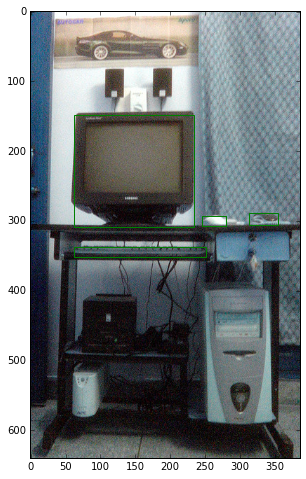

In [23]:
im_id = cap.ids[13470]
img_info =  cap.coco.loadImgs(im_id)[0]
img_name = img_info['file_name']
annIds = cap.coco.getAnnIds(imgIds=im_id, iscrowd=None)
anns = cap.coco.loadAnns(annIds)
fig,ax = plt.subplots(1)
base_path = './data/mscoco/images/train2014/'
img_path = os.path.join(base_path, img_name)
# Display the image
im_data = cv2.imread(img_path)
ax.imshow(im_data)
# Create a Rectangle patch
for i, box_anns in enumerate(anns):
    box = box_anns['bbox']
    print box
    rect = patches.Rectangle((box[0], box[1]), box[2], box[3] ,linewidth=1,edgecolor='g',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
# Add the patch to the Axes
ax.add_patch(rect)    
plt.show()

In [25]:
blobs = cap[13470]
im_data = blobs['data']
im_info = blobs['im_info']
print im_info
print im_data.shape
print blobs['boxes']
gt_boxes = np.hstack([ blobs['boxes'] , blobs['gt_classes'][:, np.newaxis]])
gt_ishard = blobs['gt_ishard']
dontcare_areas = blobs['dontcare_areas']
print blobs['boxes'] / im_info[0][2]
print blobs['image_info']
print im_data.shape
print net.classes[39]
origin_gt_box =  blobs['boxes'] / im_info[0][2]
print origin_gt_box
print gt_boxes

[[ 995.          600.            1.55440414]]
(1, 995, 600, 3)
[[ 484.97409326  449.22279793  548.70466321  472.5388601 ]
 [  96.37305699  523.83419689  388.60103627  544.04145078]
 [  94.81865285  230.05181347  362.1761658   478.75647668]
 ..., 
 [  27.97927461  495.85492228   34.19689119  512.95336788]
 [ 293.78238342  582.9015544   300.          592.22797927]
 [ 475.64766839  489.6373057   484.97409326  500.51813472]]
[[ 312.00000112  289.00000103  353.00000126  304.00000109]
 [  62.00000022  337.00000121  250.00000089  350.00000125]
 [  61.00000022  148.00000053  233.00000083  308.0000011 ]
 ..., 
 [  18.00000006  319.00000114   22.00000008  330.00000118]
 [ 189.00000068  375.00000134  193.00000069  381.00000136]
 [ 306.00000109  315.00000113  312.00000112  322.00000115]]
{u'license': 3, u'file_name': u'COCO_train2014_000000418462.jpg', u'coco_url': u'http://mscoco.org/images/418462', u'height': 640, u'width': 386, u'date_captured': u'2013-11-23 20:15:04', u'flickr_url': u'http://f

[[   0.    480.    598.75  798.75    0.  ]
 [  63.75  480.    217.5   565.      0.  ]
 [ 328.75  575.    366.25  683.75    0.  ]
 ..., 
 [ 455.    585.    466.25  598.75    0.  ]
 [ 412.5   651.25  423.75  657.5     0.  ]
 [ 155.    556.25  172.5   567.5     0.  ]]
[ 0.98720676] [1]
[[ 800.    600.      1.25]]
['__background__', u'person', u'bicycle', u'car', u'motorcycle', u'airplane', u'bus', u'train', u'truck', u'boat', u'traffic light', u'fire hydrant', u'stop sign', u'parking meter', u'bench', u'bird', u'cat', u'dog', u'horse', u'sheep', u'cow', u'elephant', u'bear', u'zebra', u'giraffe', u'backpack', u'umbrella', u'handbag', u'tie', u'suitcase', u'frisbee', u'skis', u'snowboard', u'sports ball', u'kite', u'baseball bat', u'baseball glove', u'skateboard', u'surfboard', u'tennis racket', u'bottle', u'wine glass', u'cup', u'fork', u'knife', u'spoon', u'bowl', u'banana', u'apple', u'sandwich', u'orange', u'broccoli', u'carrot', u'hot dog', u'pizza', u'donut', u'cake', u'chair', u'cou

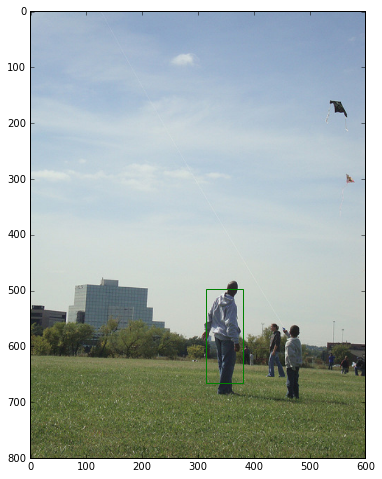

In [29]:
from scipy.misc import  imread, imresize
from faster_rcnn.fastrcnn.bbox_transform import bbox_transform_inv, clip_boxes
from faster_rcnn.faster_rcnn import nms_detections

net.eval()
blobs = cap[13500]
im_data = blobs['data']
im_info = blobs['im_info']
gt_boxes = np.hstack([ blobs['boxes'] , blobs['gt_classes'][:, np.newaxis]])
rois = gt_boxes[gt_boxes[:, 4] == 0.]
origin_gt_box = gt_boxes[gt_boxes[:, 4] != 0.]
print rois
fig,ax = plt.subplots(1)
base_path = './data/mscoco/images/train2014/'
img_path = os.path.join(base_path, blobs['im_name'])
cls_prob, bbox_pred, rois = net(im_data,im_info, rois)

scores, inds = cls_prob.data.max(1)
scores, inds = scores.cpu().numpy(), inds.cpu().numpy()

keep = np.where((inds > 0) & (scores >= 0.95))
scores, inds = scores[keep], inds[keep]

# Apply bounding-box regression deltas
keep = keep[0]
box_deltas = bbox_pred.data.cpu().numpy()[keep]
box_deltas = np.asarray([
    box_deltas[i, (inds[i] * 4): (inds[i] * 4 + 4)] for i in range(len(inds))
], dtype=np.float)
boxes = rois.data.cpu().numpy()[keep, 1:5]
pred_boxes = bbox_transform_inv(boxes, box_deltas)
pred_boxes = clip_boxes(pred_boxes, im_info[0, :2])
pred_boxes, scores, inds = nms_detections(pred_boxes, scores, 0.5, inds=inds)

print scores, inds

print im_info
# Display the image
im_data = imread(img_path)
im_data = imresize(im_data, im_info[0, :2])
rois = rois.data.cpu().numpy()[keep, 1:5]
ax.imshow(im_data)

print net.classes
# print pred_boxes.shape
# print rois.shape
# print pred_boxes[:3]
# print rois[:3]

# for i, box_data in enumerate(rois):
#     box = box_data
#     rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=1,edgecolor='b',facecolor='none')
#     # Add the patch to the Axes
#     ax.add_patch(rect)


for i, box_data in enumerate(pred_boxes):
    box = box_data
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=1,edgecolor='g',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
# for i, box_data in enumerate(origin_gt_box):
#     box = box_data
#     rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=1,edgecolor='r',facecolor='none')
#     # Add the patch to the Axes
#     ax.add_patch(rect)
    
plt.show()